<a href="https://colab.research.google.com/github/tinaghimire/AWS-ML-AI/blob/main/M2Mtrain_complete_dashain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers datasets
!pip install transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
   

In [23]:
import pandas as pd

dataset = pd.read_csv("/content/drive/MyDrive/Major/resource/Dataset_Dashain.csv")
dataset.shape

(511, 2)

In [24]:
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer, GenerationConfig
from datasets import load_dataset, load_metric
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments

from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib.font_manager import FontProperties
from sklearn.metrics import precision_recall_curve

In [ ]:
# !pip install sentencepiece
# import sentencepiece as spm

In [25]:
model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")
tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M", src_lang="en", tgt_lang="ne")

translation_generation_config = GenerationConfig(
    num_beams=5,
    early_stopping=True,
    decoder_start_token_id=0,
    eos_token_id=model.config.eos_token_id,
    pad_token=model.config.pad_token_id,
)

translation_generation_config.save_pretrained("/tmp", "translation_generation_config.json")
generation_config = GenerationConfig.from_pretrained("/tmp", "translation_generation_config.json")

In [26]:
train_df, temp_df = train_test_split(dataset, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [27]:
train_df.shape, val_df.shape, test_df.shape

((408, 2), (51, 2), (52, 2))

In [12]:
from datasets import load_dataset, DatasetDict, Dataset

In [28]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [29]:
def preprocess_function(examples):
    inputs = examples['Input']
    targets = examples['Output']

    # Tokenize inputs and targets
    # model_inputs = tokenizer(inputs, max_length=128, padding=True, truncation=True, return_tensors="pt")
    model_inputs = tokenizer(inputs, padding=True, truncation=True, return_tensors="pt")

    with tokenizer.as_target_tokenizer():
        # labels = tokenizer(targets, max_length=128, padding=True, truncation=True, return_tensors="pt")
        labels = tokenizer(targets, padding=True, truncation=True, return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [30]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/52 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Input', 'Output', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 408
    })
    validation: Dataset({
        features: ['Input', 'Output', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['Input', 'Output', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 52
    })
})

In [31]:
from transformers import TrainerCallback

In [32]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/output",
    logging_dir="/content/logs",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="steps",    	    # Evaluate after each epoch
    logging_strategy="steps",       # Log metrics after each epoch
    save_steps=100,
    eval_steps=100,
    logging_first_step=True,
    logging_nan_inf_filter=True,
    save_strategy="steps",          # Save checkpoint after each epoch
    learning_rate= 2e-5,
    per_device_train_batch_size=1,  # Default to 8
    per_device_eval_batch_size=2,
    weight_decay=0.2,
    save_total_limit=2,             # Limit total number of checkpoints to save
    logging_steps=100,
    max_steps=4000,
    lr_scheduler_type="cosine_with_restarts",
    warmup_steps=800,
    restore_callback_states_from_checkpoint=True, # Restores callback states from the checkpoint if they exist
    report_to="none",
    predict_with_generate=True,
    dataloader_drop_last=True,
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model="eval_loss",
    ignore_data_skip=False,          # Ensures training resumes with aligned data loading
    greater_is_better=False,         # eval_loss smaller is better
    fp16=True,                       # Enable if you're using compatible hardware
)

In [33]:
!pip install sacrebleu
!pip install rouge_score
!pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0434d0bf819903aab8030ed4802f29df6fd5b548c1340d498fc3e715ad8123ea
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.7 MB/s eta 0:00:00


In [34]:
from datasets import load_metric
from sklearn.metrics import precision_score, recall_score, f1_score
from bert_score import score

In [44]:
bleu = []
meteor = []
ter = []
chrf = []
f1_list = []

bleu_metric = load_metric("sacrebleu", trust_remote_code=True)
meteor_metric = load_metric("meteor", trust_remote_code=True)
ter_metric = load_metric("ter", trust_remote_code=True)
chrf_metric = load_metric("chrf", trust_remote_code=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    bleu_result = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_result = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)
    ter_result = ter_metric.compute(predictions=decoded_preds, references=decoded_labels)
    chrf_result = chrf_metric.compute(predictions=decoded_preds, references=decoded_labels)

    bleu.append(bleu_result["score"])
    meteor.append(meteor_result["meteor"])
    ter.append(ter_result["score"])
    chrf.append(chrf_result["score"])

    precision, recall, f1 = score(decoded_preds, decoded_labels, lang='ne', model_type='xlm-roberta-base')

    f1_list.append(f1.mean().item())

    result = {
        "precision": precision.mean().item(),
        "recall": recall.mean().item(),
        "f1 score": f1.mean().item(),
        "bleu": bleu_result['score'],
        "meteor": meteor_result["meteor"],
        "ter": ter_result["score"],
        "chrf": chrf_result["score"],
    }

    return result

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [36]:
from transformers import TrainerState
from transformers.trainer_callback import TrainerCallback
from transformers.trainer_callback import EarlyStoppingCallback

In [37]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=5,  # Number of evaluation steps with no improvement to wait
    early_stopping_threshold=0.0001  # Minimum change to qualify as an improvement
)

In [38]:
from transformers import TrainerCallback
import pandas as pd

class LossLoggerCallback(TrainerCallback):
    def __init__(self, save_steps=100):
        super().__init__()
        self.train_losses = []
        self.eval_losses = [0.000]

    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_world_process_zero:
            if logs is not None:
                if "loss" in logs:
                    self.train_losses.append(logs["loss"])
                    # print(self.train_losses)
                if "eval_loss" in logs:
                    self.eval_losses.append(logs["eval_loss"])
                    # print(self.eval_losses)

    def on_train_end(self, args, state, control, **kwargs):
        # Create a DataFrame from the lists of losses
        df = pd.DataFrame({
            'train_loss': self.train_losses,
            'eval_loss': self.eval_losses
        })
        print(self.train_losses)
        print(self.eval_losses)

        # Save DataFrame to CSV
        df.to_csv("/content/losses.csv", index=False)
        print("Training and evaluation losses saved to losses.csv")

In [45]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[LossLoggerCallback(), early_stopping],
)

max_steps is given, it will override any value given in num_train_epochs


In [46]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1 score,Bleu,Meteor,Ter,Chrf
100,5.069100,4.925112,0.856658,0.846825,0.851031,3.500388,0.168423,215.643275,21.706608
200,4.611700,3.991498,0.883464,0.884128,0.883520,8.740757,0.269786,151.461988,33.067625
300,3.664700,3.208605,0.896476,0.895123,0.895571,15.250499,0.275606,85.233918,36.968959
400,2.919100,2.342480,0.899310,0.903230,0.901044,15.621536,0.305314,84.356725,40.633758
500,1.926200,1.481411,0.891932,0.904425,0.897913,13.141529,0.291956,104.970760,39.668905
600,1.260200,1.085254,0.920861,0.873309,0.896178,6.692799,0.241901,78.654971,28.747048
700,0.941400,0.935453,0.903396,0.905491,0.904236,17.424144,0.309822,82.456140,40.217447
800,0.843400,0.892456,0.898709,0.906942,0.902515,15.881766,0.313865,86.257310,42.974223
900,0.734000,0.853437,0.924735,0.898132,0.910921,15.799968,0.292598,74.561404,39.214169
1000,0.662500,0.809804,0.927011,0.900557,0.913246,17.716973,0.318658,69.883041,40.064725


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instea

[7.1813, 5.0691, 4.6117, 3.6647, 2.9191, 1.9262, 1.2602, 0.9414, 0.8434, 0.734, 0.6625, 0.7014, 0.6527, 0.5441, 0.5359, 0.4929, 0.4863, 0.4341, 0.3928, 0.3657, 0.3482, 0.3214, 0.2892, 0.2896, 0.2693, 0.2709, 0.1951, 0.2224, 0.193, 0.1745, 0.1654, 0.1521, 0.1464, 0.1189, 0.1346, 0.1096, 0.1155]
[0.0, 4.925111770629883, 3.99149751663208, 3.2086052894592285, 2.342479705810547, 1.4814114570617676, 1.085254430770874, 0.9354525208473206, 0.8924555778503418, 0.8534365892410278, 0.8098041415214539, 0.768425464630127, 0.7312993407249451, 0.7244951725006104, 0.6950399279594421, 0.6859252452850342, 0.6957915425300598, 0.6810769438743591, 0.6619765758514404, 0.6530129313468933, 0.6428806185722351, 0.6606177687644958, 0.6732333898544312, 0.6425693035125732, 0.6400123834609985, 0.632429301738739, 0.6490328907966614, 0.6282855272293091, 0.6347519159317017, 0.632062554359436, 0.637352466583252, 0.6261137127876282, 0.6286141872406006, 0.6308863759040833, 0.6308231353759766, 0.6302459239959717, 0.633482

TrainOutput(global_step=3600, training_loss=0.8548738190862868, metrics={'train_runtime': 5630.8157, 'train_samples_per_second': 0.71, 'train_steps_per_second': 0.71, 'total_flos': 312367811788800.0, 'train_loss': 0.8548738190862868, 'epoch': 8.823529411764707})

In [47]:
max_bleu = max(bleu)
max_bleu

34.972271776650175

In [48]:
from datetime import datetime

# Get the current date
current_date = datetime.now().date()
print("Current Date:", current_date)

Current Date: 2024-07-30


In [49]:
max_step = 4000
trainer.save_model(f"/content/drive/MyDrive/Major/M2M/output_{current_date}_{max_bleu}")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}


In [50]:
import shutil

# Replace 'folder_to_save' with the actual path to your folder in Colab
shutil.copytree('/content/output', f'/content/drive/MyDrive/Major/M2M/output/checkpoints_{current_date}_{max_bleu}')

'/content/drive/MyDrive/Major/M2M/output/checkpoints_2024-07-30_34.972271776650175'

In [52]:
loss_callback = next(callback for callback in trainer.callback_handler.callbacks if isinstance(callback, LossLoggerCallback))
train_losses = loss_callback.train_losses
eval_losses = loss_callback.eval_losses

# Print the collected losses
print("Training Losses:", train_losses)
print("Validation Losses:", eval_losses)
print("BLEU:", bleu)
print("METEOR:", meteor)
print("TER:", ter)
print("F1 score", f1_list)
print("CHRF", chrf)

Training Losses: [7.1813, 5.0691, 4.6117, 3.6647, 2.9191, 1.9262, 1.2602, 0.9414, 0.8434, 0.734, 0.6625, 0.7014, 0.6527, 0.5441, 0.5359, 0.4929, 0.4863, 0.4341, 0.3928, 0.3657, 0.3482, 0.3214, 0.2892, 0.2896, 0.2693, 0.2709, 0.1951, 0.2224, 0.193, 0.1745, 0.1654, 0.1521, 0.1464, 0.1189, 0.1346, 0.1096, 0.1155]
Validation Losses: [0.0, 4.925111770629883, 3.99149751663208, 3.2086052894592285, 2.342479705810547, 1.4814114570617676, 1.085254430770874, 0.9354525208473206, 0.8924555778503418, 0.8534365892410278, 0.8098041415214539, 0.768425464630127, 0.7312993407249451, 0.7244951725006104, 0.6950399279594421, 0.6859252452850342, 0.6957915425300598, 0.6810769438743591, 0.6619765758514404, 0.6530129313468933, 0.6428806185722351, 0.6606177687644958, 0.6732333898544312, 0.6425693035125732, 0.6400123834609985, 0.632429301738739, 0.6490328907966614, 0.6282855272293091, 0.6347519159317017, 0.632062554359436, 0.637352466583252, 0.6261137127876282, 0.6286141872406006, 0.6308863759040833, 0.6308231353

In [54]:
import os
import json

path = f"/content/drive/MyDrive/Major/M2M/output/output_{current_date}_{max_bleu}/res/"
os.makedirs(path, exist_ok=True)  # Ensure the directory exists

try:
    with open(os.path.join(path, "data.json"), "r") as f:
        score_dict = json.load(f)
except (FileNotFoundError, json.JSONDecodeError):
    score_dict = {
        "steps": [],
        "bleu": [0.000],
        "train_loss": [],
        "eval_loss": [],
        "f1 score": [],
        "meteor": [0.000],
        "ter": [0.000],
        "chrf": [0.000]
    }

last_step = score_dict["steps"][-1] if score_dict["steps"] else -100
step_start = (last_step // 100 + 1) * 100
steps = [i for i in range(step_start, step_start + 100 * len(bleu) + 100, 100)]

# Append new values to the existing lists
score_dict["steps"].extend(steps)
score_dict["bleu"].extend(bleu)
score_dict["train_loss"].extend(train_losses)
score_dict["eval_loss"].extend(eval_losses)
score_dict["f1 score"].extend(f1_list)
score_dict["meteor"].extend(meteor)
score_dict["ter"].extend(ter)
score_dict["chrf"].extend(chrf)

# Print or save score_dict as needed
print(score_dict)

{'steps': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600], 'bleu': [0.0, 3.5003875515152187, 8.740757294792676, 15.250498560120379, 15.6215364687162, 13.141529464027881, 6.692798583921042, 17.424144472545628, 15.881766304164328, 15.799968367050303, 17.716973064745275, 18.325337306040627, 20.797948742192027, 21.37645964394536, 21.52844375079786, 22.838236651890767, 25.037310938266256, 27.320755443213233, 26.506625665450787, 25.250433891598405, 24.868911774795055, 27.569384544487374, 27.41475909401914, 30.157113549220114, 27.02773022087328, 28.515108881697127, 28.19187314595005, 29.830288905104858, 32.650424304377005, 31.01715987725321, 28.820627388663105, 28.430562339642012, 30.98540499357715, 33.67329060245319, 33.37387698974857, 34.972271776650175, 34.76481779342963], 'train_loss': [7.1813, 5.0691, 4.6117, 3.6647, 2.9191, 1.

In [55]:
import numpy as np
import json

# Assuming you have a dictionary named 'score_dict'
with open(os.path.join(path, "data.json"), "w") as f:
    json.dump(score_dict, f, indent=4)

print("Score saved to 'data.json' file.")

Score saved to 'data.json' file.


In [57]:
# Load metrics
rouge_metric = load_metric("rouge", trust_remote_code=True)
eval_dataset = tokenized_dataset["validation"]

# Evaluate the model
results = trainer.predict(test_dataset=eval_dataset)

# Extract predictions and labels
predictions = results.predictions
labels = results.label_ids

# Decode predictions and labels
decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

# Compute ROUGE scores
rouge_result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)

# Compile results
result = {
    "rouge1": rouge_result["rouge1"].mid.fmeasure,
    "rouge2": rouge_result["rouge2"].mid.fmeasure,
    "rougeL": rouge_result["rougeL"].mid.fmeasure,
}

In [58]:
print(result)

{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}


In [59]:
# Assuming you have a dictionary named 'score_dict'
with open(os.path.join(path, "rouge_data.json"), "w") as f:
    json.dump(result, f, indent=4)

print("Score saved to 'rouge_data.json' file.")

Score saved to 'rouge_data.json' file.


In [60]:
steps = score_dict["steps"]
bleu = score_dict["bleu"]
train_losses = score_dict["train_loss"]
eval_losses = score_dict["eval_loss"]
f1 = score_dict["f1 score"]
meteor = score_dict["meteor"]
ter = score_dict["ter"]
chrf = score_dict["chrf"]

In [61]:
path = f"/content/drive/MyDrive/Major/M2M/output/output_{current_date}_{max_bleu}/res/"  # Replace with the actual path where you want to save the plots

# Load custom fonts
times_new_roman_font = FontProperties(fname='/content/drive/MyDrive/Major/resource/times-new-roman.ttf', size=11)
arial_font = FontProperties(fname='/content/drive/MyDrive/Major/resource/arial.ttf', size=11)

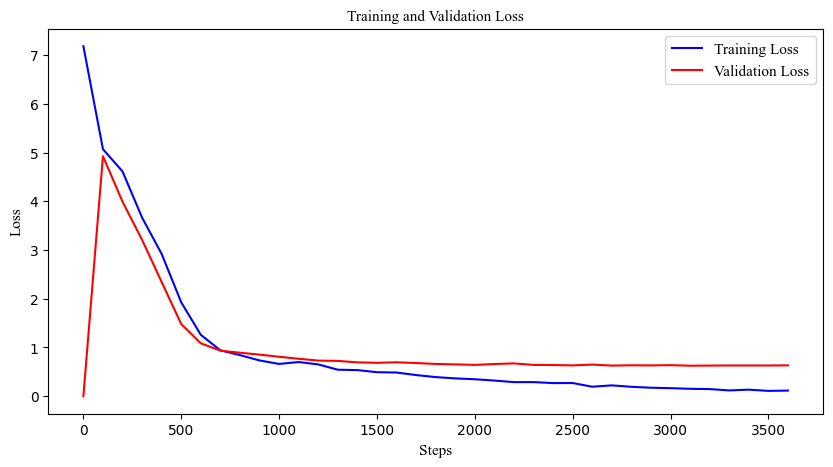

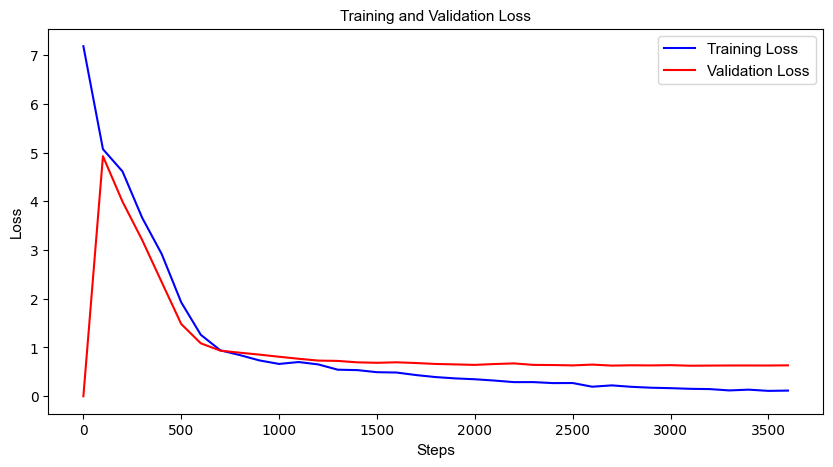

In [63]:
import matplotlib.pyplot as plt

plot_path_times_new_roman = os.path.join(path, "loss_plot_times_new_roman.png")
plot_path_arial = os.path.join(path, "loss_plot_arial.png")

# Plot with Times New Roman
plt.figure(figsize=(10, 5))
plt.plot(score_dict["steps"], score_dict["train_loss"], 'b', label='Training Loss')
plt.plot(score_dict["steps"], score_dict["eval_loss"], 'r', label='Validation Loss')
plt.title('Training and Validation Loss', fontproperties=times_new_roman_font)
plt.xlabel('Steps', fontproperties=times_new_roman_font)
plt.ylabel('Loss', fontproperties=times_new_roman_font)
plt.legend(prop=times_new_roman_font)
plt.savefig(plot_path_times_new_roman, dpi=600)
plt.show()

# Plot with Arial
plt.figure(figsize=(10, 5))
plt.plot(score_dict["steps"], score_dict["train_loss"], 'b', label='Training Loss')
plt.plot(score_dict["steps"], score_dict["eval_loss"], 'r', label='Validation Loss')
plt.title('Training and Validation Loss', fontproperties=arial_font)
plt.xlabel('Steps', fontproperties=arial_font)
plt.ylabel('Loss', fontproperties=arial_font)
plt.legend(prop=arial_font)
plt.savefig(plot_path_arial, dpi=600)
plt.show()

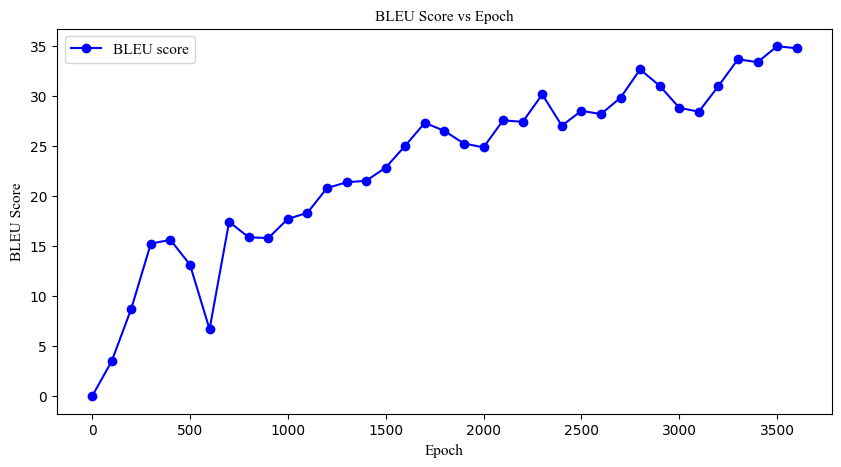

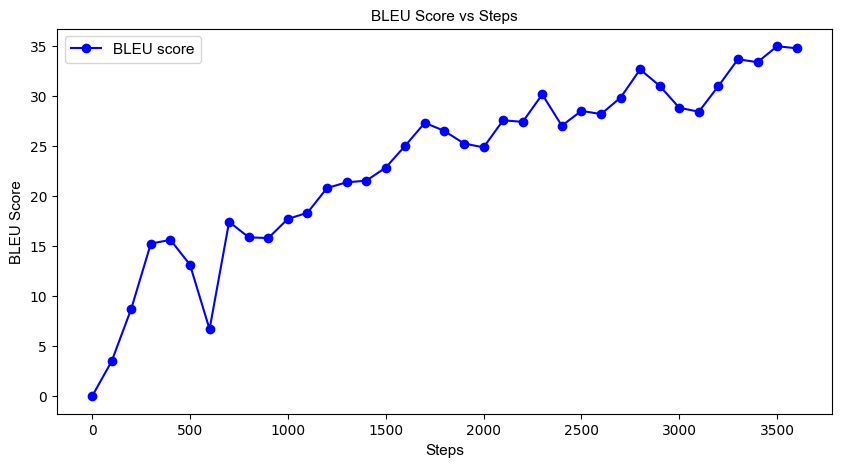

In [64]:
# Paths to save the plots
plot_path_times_new_roman = os.path.join(path, "bleu_score_times_new_roman.png")
plot_path_arial = os.path.join(path, "bleu_score_arial.png")

# Plot with Times New Roman
plt.figure(figsize=(10, 5))
plt.plot(score_dict["steps"], score_dict["bleu"], marker='o', linestyle='-', color='b', label='BLEU score')
plt.title('BLEU Score vs Epoch', fontproperties=times_new_roman_font)
plt.xlabel('Epoch', fontproperties=times_new_roman_font)
plt.ylabel('BLEU Score', fontproperties=times_new_roman_font)
plt.legend(prop=times_new_roman_font)

plt.savefig(plot_path_times_new_roman, dpi=600)
plt.show()

# Plot with Arial
plt.figure(figsize=(10, 5))
plt.plot(score_dict["steps"], score_dict["bleu"], marker='o', linestyle='-', color='b', label='BLEU score')
plt.title('BLEU Score vs Steps', fontproperties=arial_font)
plt.xlabel('Steps', fontproperties=arial_font)
plt.ylabel('BLEU Score', fontproperties=arial_font)
plt.legend(prop=arial_font)

plt.savefig(plot_path_arial, dpi=600)
plt.show()

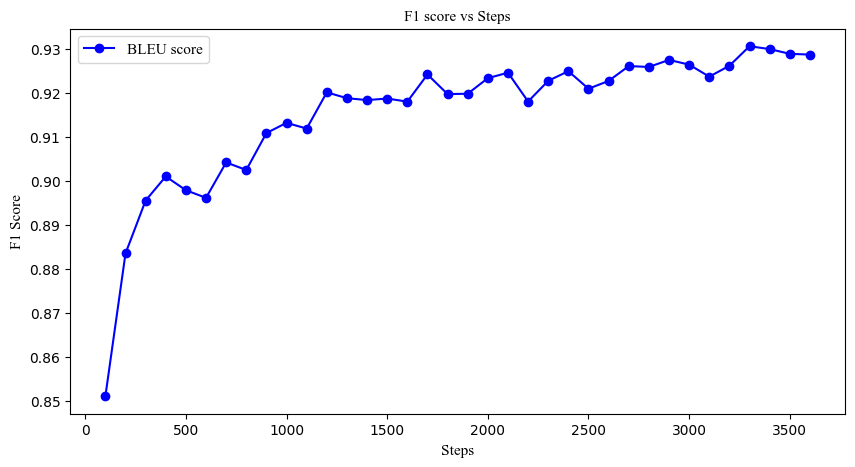

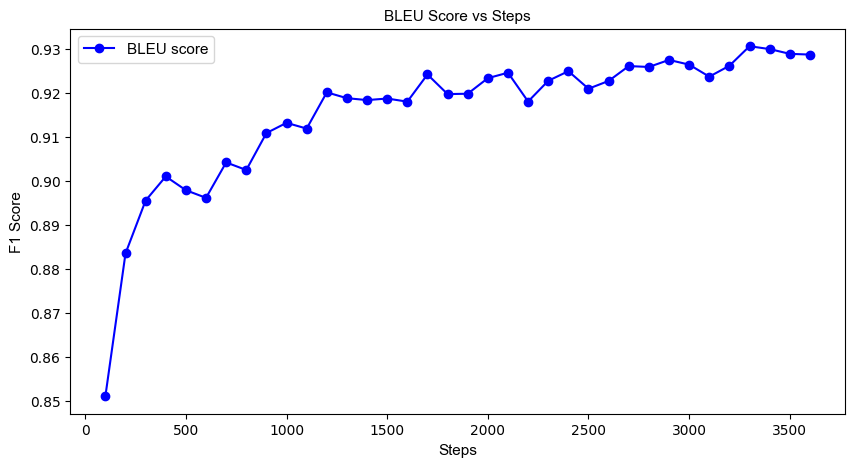

In [67]:
# Paths to save the plots
plot_path_times_new_roman = os.path.join(path, "f1_score_times_new_roman.png")
plot_path_arial = os.path.join(path, "f1_score_arial.png")

# Plot with Times New Roman
plt.figure(figsize=(10, 5))
plt.plot(score_dict["steps"][1:], score_dict["f1 score"], marker='o', linestyle='-', color='b', label='BLEU score')
plt.title('F1 score vs Steps', fontproperties=times_new_roman_font)
plt.xlabel('Steps', fontproperties=times_new_roman_font)
plt.ylabel('F1 Score', fontproperties=times_new_roman_font)
plt.legend(prop=times_new_roman_font)

plt.savefig(plot_path_times_new_roman, dpi=600)
plt.show()

# Plot with Arial
plt.figure(figsize=(10, 5))
plt.plot(score_dict["steps"][1:], score_dict["f1 score"], marker='o', linestyle='-', color='b', label='BLEU score')
plt.title('BLEU Score vs Steps', fontproperties=arial_font)
plt.xlabel('Steps', fontproperties=arial_font)
plt.ylabel('F1 Score', fontproperties=arial_font)
plt.legend(prop=arial_font)

plt.savefig(plot_path_arial, dpi=600)
plt.show()

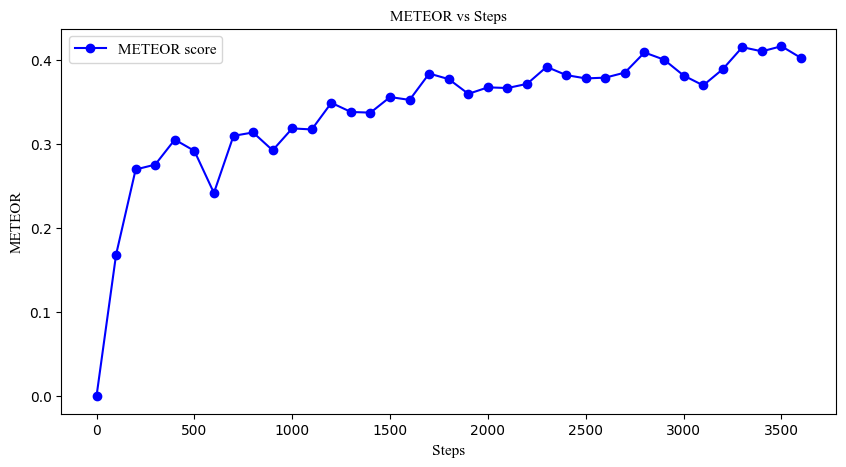

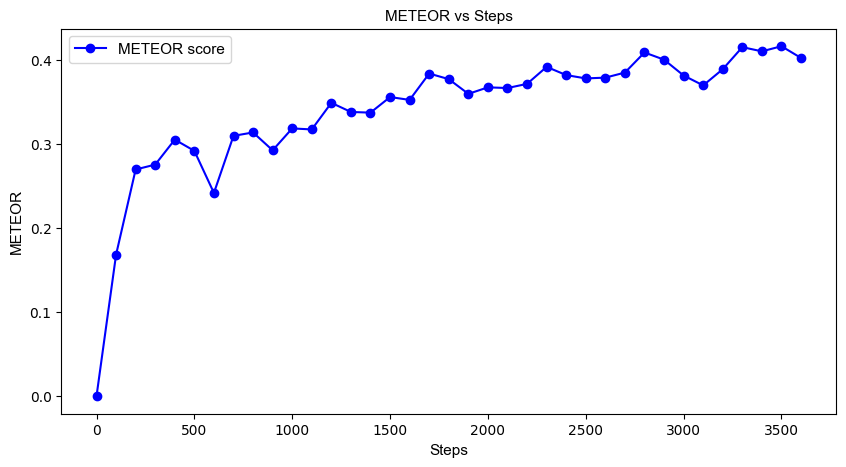

In [69]:
plot_path_times_new_roman = os.path.join(path, "meteor_score_times_new_roman.png")
plot_path_arial = os.path.join(path, "meteor_score_arial.png")

# Plot with Times New Roman
plt.figure(figsize=(10, 5))
plt.plot(score_dict["steps"], score_dict["meteor"], marker='o', linestyle='-', color='b', label='METEOR score')
plt.title('METEOR vs Steps', fontproperties=times_new_roman_font)
plt.xlabel('Steps', fontproperties=times_new_roman_font)
plt.ylabel('METEOR', fontproperties=times_new_roman_font)
plt.legend(prop=times_new_roman_font)

plt.savefig(plot_path_times_new_roman, dpi=600)
plt.show()

# Plot with Arial
plt.figure(figsize=(10, 5))
plt.plot(score_dict["steps"], score_dict["meteor"], marker='o', linestyle='-', color='b', label='METEOR score')
plt.title('METEOR vs Steps', fontproperties=arial_font)
plt.xlabel('Steps', fontproperties=arial_font)
plt.ylabel('METEOR', fontproperties=arial_font)
plt.legend(prop=arial_font)

plt.savefig(plot_path_arial, dpi=600)
plt.show()

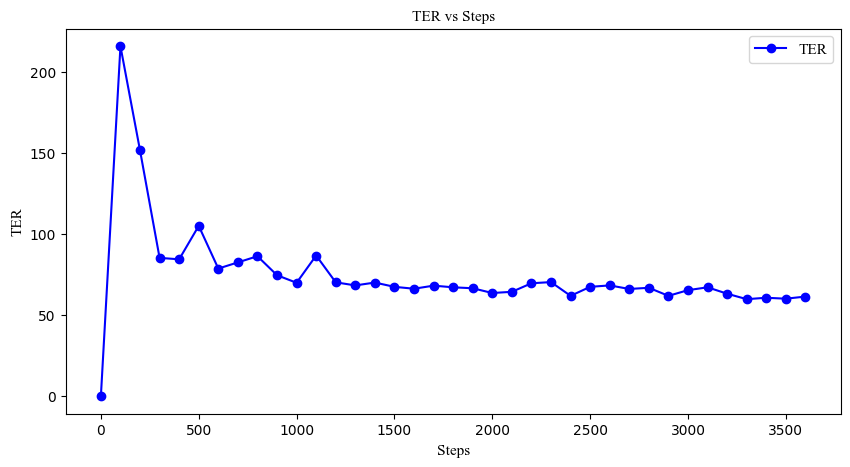

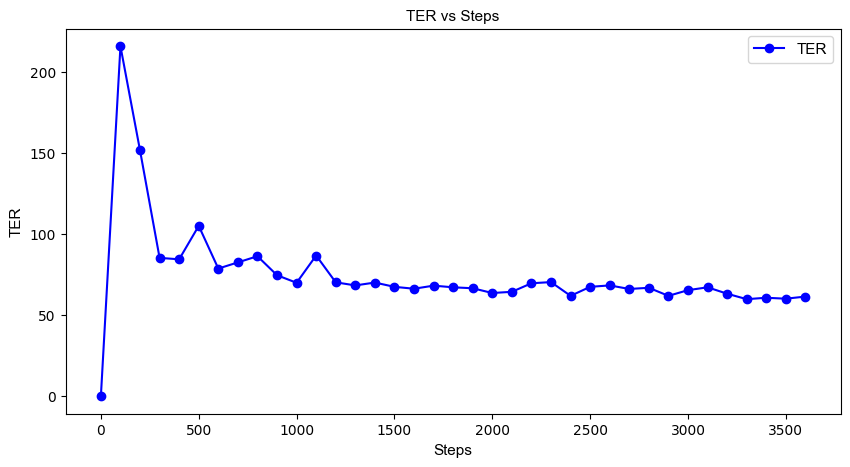

In [71]:
# Paths to save the plots
plot_path_times_new_roman = os.path.join(path, "ter_score_times_new_roman.png")
plot_path_arial = os.path.join(path, "ter_score_arial.png")

# Plot with Times New Roman
plt.figure(figsize=(10, 5))
plt.plot(score_dict["steps"], score_dict["ter"], marker='o', linestyle='-', color='b', label='TER')
plt.title('TER vs Steps', fontproperties=times_new_roman_font)
plt.xlabel('Steps', fontproperties=times_new_roman_font)
plt.ylabel('TER', fontproperties=times_new_roman_font)
plt.legend(prop=times_new_roman_font)

plt.savefig(plot_path_times_new_roman, dpi=600)
plt.show()

# Plot with Arial
plt.figure(figsize=(10, 5))
plt.plot(score_dict["steps"], score_dict["ter"], marker='o', linestyle='-', color='b', label='TER')
plt.title('TER vs Steps', fontproperties=arial_font)
plt.xlabel('Steps', fontproperties=arial_font)
plt.ylabel('TER', fontproperties=arial_font)
plt.legend(prop=arial_font)

plt.savefig(plot_path_arial, dpi=600)
plt.show()

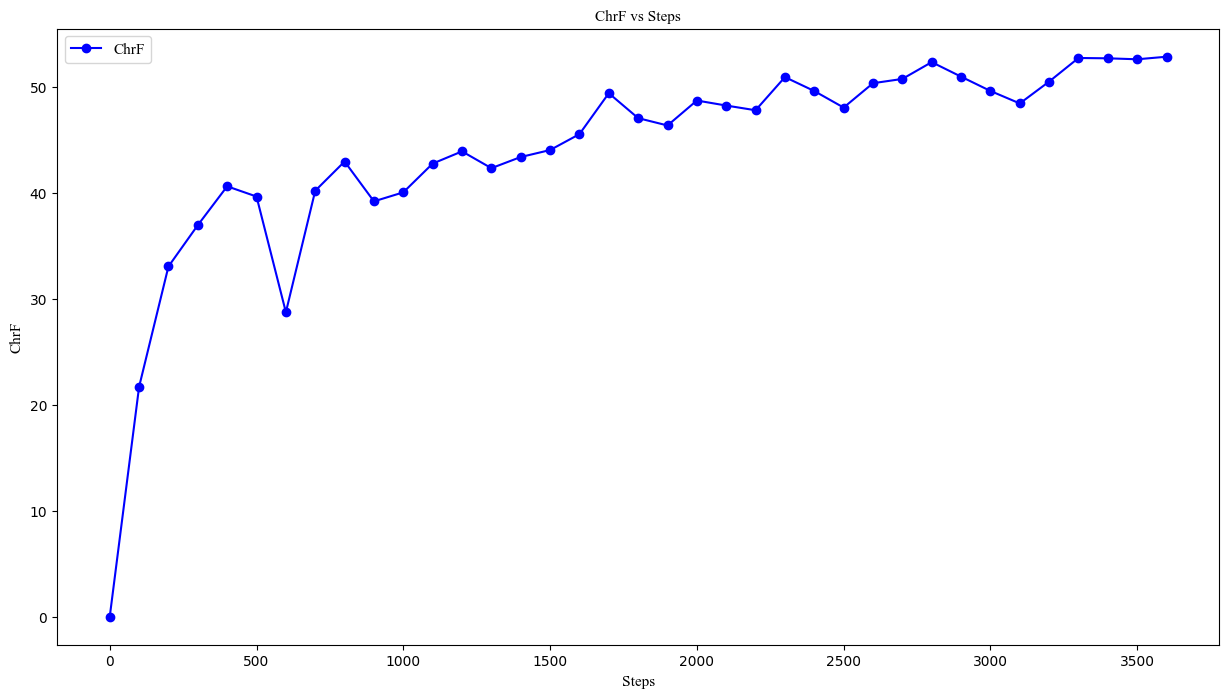

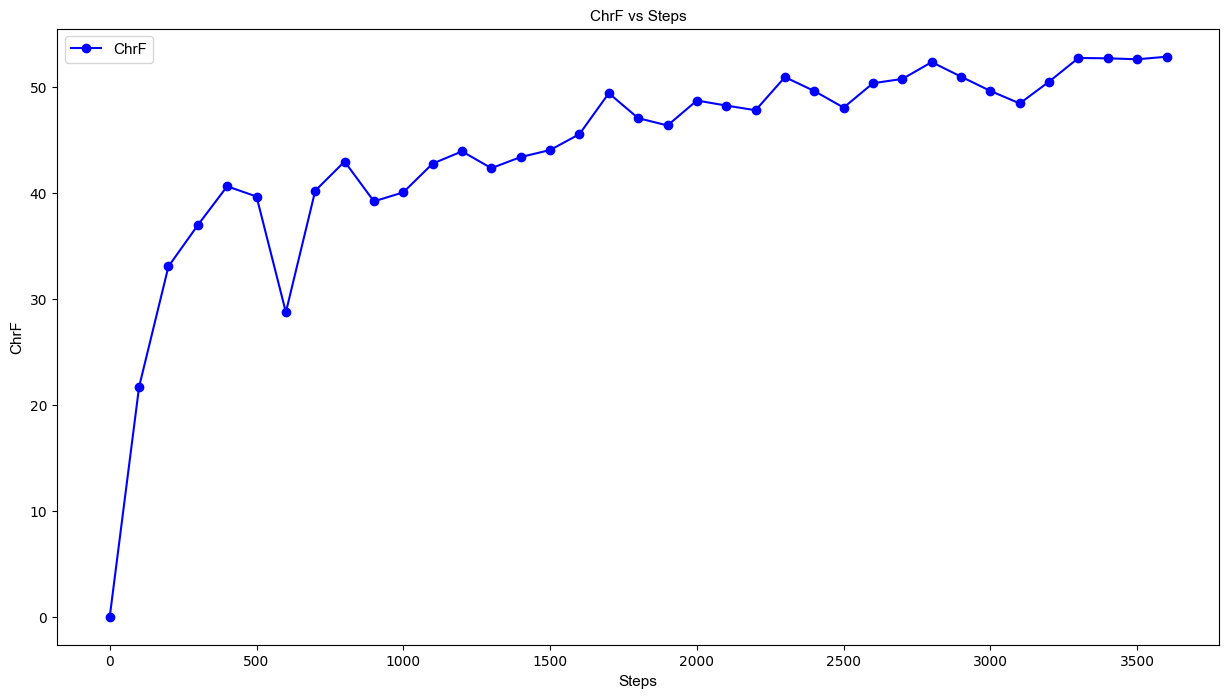

In [73]:
plot_path_times_new_roman = os.path.join(path, "chrf_times_new_roman.png")
plot_path_arial = os.path.join(path, "chrf_arial.png")

# Plot with Times New Roman
plt.figure(figsize=(15, 8))
plt.plot(steps, chrf, marker='o', linestyle='-', color='b', label='ChrF')
plt.title('ChrF vs Steps', fontproperties=times_new_roman_font)
plt.xlabel('Steps', fontproperties=times_new_roman_font)
plt.ylabel('ChrF', fontproperties=times_new_roman_font)
plt.legend(prop=times_new_roman_font)

plt.savefig(plot_path_times_new_roman, dpi=600)
plt.show()

# Plot with Arial
plt.figure(figsize=(15, 8))
plt.plot(steps, chrf, marker='o', linestyle='-', color='b', label='ChrF')
plt.title('ChrF vs Steps', fontproperties=arial_font)
plt.xlabel('Steps', fontproperties=arial_font)
plt.ylabel('ChrF', fontproperties=arial_font)
plt.legend(prop=arial_font)

plt.savefig(plot_path_arial, dpi=600)
plt.show()

In [ ]:
# test_results = trainer.evaluate(tokenized_dataset["test"])
# print(test_results)

In [74]:
model_dir = f"/content/drive/MyDrive/Major/M2M/output_{current_date}_{max_bleu}"

model = M2M100ForConditionalGeneration.from_pretrained(model_dir)
tokenizer = M2M100Tokenizer.from_pretrained(model_dir)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [75]:
# @title Default title text
results = []

for i, data in enumerate(tokenized_dataset["test"]):
    inputs = tokenizer(data['Input'], return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    outputs = model.generate(
            **inputs,
            do_sample=True,            # Enable sampling
            top_k=50,                  # Limit to the top 50 token choices at each step
            top_p=0.90,                # Use top-p (nucleus) sampling
            temperature=0.5,           # Lower temperature for less randomness
            num_return_sequences=2     # Number of sequences to generate
        )

    generated_text_1 = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_text_2 = tokenizer.decode(outputs[1], skip_special_tokens=True)
    results.append({
        "Input": data['Input'],
        "Expected Output": data['Output'],
        "Prediction 1": generated_text_1,
        "Prediction 2": generated_text_2
    })

df = pd.DataFrame(results)
print(df.to_string(index=False))

                                                                                                                                         Input                                                                                                                         Expected Output                                                                                                                                      Prediction 1                                                                                                                                 Prediction 2
                                          Make a joyful Dashain post for 2052, extending warm wishes to all celebrating this special festival.                                                                   विजया दशमी २०५२ को पावन अवसरमा आनन्द र उत्साहको साथ हार्दिक शुभकामना!                                  विजया दशमी २०५२ को पावन अवसरमा, हर्ष र उत्साहका साथ सबैलाई हार्दिक शुभकामना! तपाईंको उत्सव खुशीले भरिपूर्ण होस्।          

In [76]:
from IPython.display import display
display(df)

,Input,Expected Output,Prediction 1,Prediction 2
0,"Make a joyful Dashain post for 2052, extending...",विजया दशमी २०५२ को पावन अवसरमा आनन्द र उत्साहक...,"विजया दशमी २०५२ को पावन अवसरमा, हर्ष र उत्साहक...","विजया दशमी २०५२ को पावन अवसरमा, हर्ष र उत्साहक..."
1,Design a Dashain greeting banner for 2074.,२०७४ को दशैंको अवसरमा हार्दिक मंगलमय शुभकामना!...,सम्पूर्ण परिवार र मित्रहरूलाई २०७४ सालको बडा द...,सम्पूर्ण परिवार र मित्रहरूलाई २०७४ सालको बडा द...
2,Create a card wishing Dashain 2072.,२०७२ को दशैंमा सम्पूर्णलाई हार्दिक शुभकामना!यो...,"२०७२ को दशैंको अवसरमा समृद्धि, स्वास्थ्य र आनन...",२०७२ को दशैंमा सम्पूर्णलाई शुभकामना! यो दशैंले...
3,Prepare a festive Dashain wish for 2060 in det...,दशैं २०६० को शुभकामना! यो विशेष अवसरले तपाईंला...,दशैं २०६० को शुभकामना! यो चाडपर्वले तपाईंको जी...,दशैं २०६० को शुभकामना! यो चाडपर्वले तपाईंको जी...
4,Make a joyful Dashain post for 2064.,विजया दशमी २०६४ को पावन अवसरमा हार्दिक मंगलमय ...,विजया दशमी २०६४ को पावन अवसरमा हार्दिक मंगलमय ...,विजया दशमी २०६४ को पावन अवसरमा हार्दिक मंगलमय ...
5,"Make a joyful Dashain post for 2046, extending...","विजया दशमी २०४६ को पावन अवसरमा, नजिक र टाढामा ...","विजया दशमी २०४६ को पावन अवसरमा, नजिक र टाढाका ...","विजया दशमी २०४६ को पावन अवसरमा, नजिक र टाढामा ..."
6,"Craft a festive Dashain greeting for 2051, sha...","दशैं २०५१ को अवसरमा, नजिक र टाढाका हरेक घरमा आ...",प्रत्येक घरमा आनन्दमय वातावरण प्रसारण गर्दै दश...,"दशैं २०५१ को अवसरमा, नजिक र टाढाका हरेक घरमा आ..."
7,Generate a festive Dashain banner for 2063.,दशैं २०६३ को शुभकामना! यस पर्वले तपाईं र तपाईं...,दशैं २०६३ को शुभकामना! यस उत्सवले तपाईंको जीवन...,दशैं २०६३ को शुभकामना! यो पर्वले तपाईंको जीवनल...
8,Design a poster for Vijaya Dashami 2077.,२०७७ सालको विजया दशमीको शुभ उपलक्ष्यमा सम्पूर्...,२०७७ सालको विजया दशमीको शुभ उपलक्ष्यमा सम्पूर्...,२०७७ सालको विजया दशमीको आनन्दमय शुभकामना! यो द...
9,"Design a heartfelt Dashain wish for 2047, offe...","यस विजया दशमी २०४७ को अवसरमा सबै परिवारलाई, जह...",यस विजया दशमी २०४७ को हरेक परिवारलाई हृदयस्पर्...,विजया दशमी २०४७ को हरेक परिवारलाई हृदयस्पर्शी ...


In [79]:
def generate_title(data):
  inputs = tokenizer(data, return_tensors="pt")
  inputs = {k: v.to(model.device) for k, v in inputs.items()}

  outputs = model.generate(
          **inputs,
          do_sample=True,            # Enable sampling
          top_k=50,                  # Limit to the top 50 token choices at each step
          top_p=0.90,                # Use top-p (nucleus) sampling
          temperature=0.5,           # Lower temperature for less randomness
          num_return_sequences=2     # Number of sequences to generate
      )

  generated_text_1 = tokenizer.decode(outputs[0], skip_special_tokens=True)
  generated_text_2 = tokenizer.decode(outputs[1], skip_special_tokens=True)

  return data, generated_text_1, generated_text_2

In [81]:
data = "Create a poster wishing every family a blessed Dashain 2070."
data, generated_text_1, generated_text_2 = generate_title(data)
data, generated_text_1, generated_text_2

('Create a poster wishing every family a blessed Dashain 2070.',
 'सम्पूर्ण परिवारलाई धन्य दशैं २०७० को शुभकामना!',
 'हरेक परिवारलाई धन्य दशैं २०७० को शुभकामना!')

In [82]:
data = "Create a poster wishing every family a blessed Dashain 2070 in detail."
data, generated_text_1, generated_text_2 = generate_title(data)
data, generated_text_1, generated_text_2

('Create a poster wishing every family a blessed Dashain 2070 in detail.',
 'सम्पूर्ण परिवारलाई २०७० सालको बडा दशैंको हार्दिक शुभकामना! यो शुभ अवसरले तपाईको घरमा सुख र समृद्धिले भरिपूर्ण होस्।',
 'सम्पूर्ण परिवारलाई २०७० सालको बडा दशैंको हार्दिक शुभकामना! यो दशैंले हरेकमा सुख र समृद्धिको कामना गर्दछौं।')

In [83]:
data = "Create a poster wishing every family a blessed Dashain 2070 in short."
data, generated_text_1, generated_text_2 = generate_title(data)
data, generated_text_1, generated_text_2

('Create a poster wishing every family a blessed Dashain 2070 in short.',
 'दशैं २०७० मा खुशी र समृद्धिको शुभकामना!',
 '२०७० को दशैंमा हरेक परिवारलाई धन्य र समृद्धिको शुभकामना!')

In [84]:
data = "Create a Christmas poster wishing every family."
data, generated_text_1, generated_text_2 = generate_title(data)
data, generated_text_1, generated_text_2

('Create a Christmas poster wishing every family.',
 'हरेक परिवारलाई दशैं २०८० को शुभकामना! यो पर्वले तपाईंको घरमा खुशी र समृद्धि ल्याओस्।',
 'हरेक परिवारलाई दशैं २०८० को शुभकामना! यो पर्वले तपाईं र तपाईंको परिवारलाई खुशी र समृद्धि ल्याओस्।')

In [85]:
data = "Create Happy birthday poster to my father"
data, generated_text_1, generated_text_2 = generate_title(data)
data, generated_text_1, generated_text_2

('Create Happy birthday poster to my father',
 'हरेक परिवारलाई शुभ दशैंको शुभकामना! यो पर्वले तपाईंको घरमा खुशी र समृद्धि ल्याओस्।',
 '२०७६ को दशैंको उपलक्ष्यमा सम्पूर्ण परिवार र मित्रहरूलाई शुभकामना!')